In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

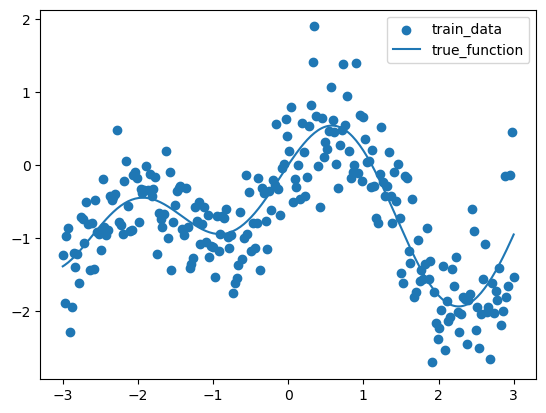

In [4]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [5]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [6]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [7]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

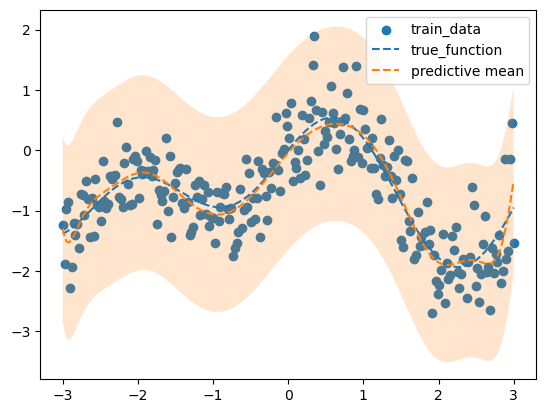

In [8]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [9]:
def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''

Домашка
Нужно взять вот этот код с данными и реализовать выбор оптимальной лямбды через MLE 2-ого типа. Сделать вывод что получилось

Дедлайн: пока хз, но ожидайте примерно 2 недели

Как сдавать: делайте гитхаб для курса и туда закидывайте домашки, ссылку кидать через гугл форму, которую сделаю позже

P.S: результаты могут разные получаться - все зависит от природы данных

optimum lambda: 4.1941
Log-evidence for opt lambda: -264.6906


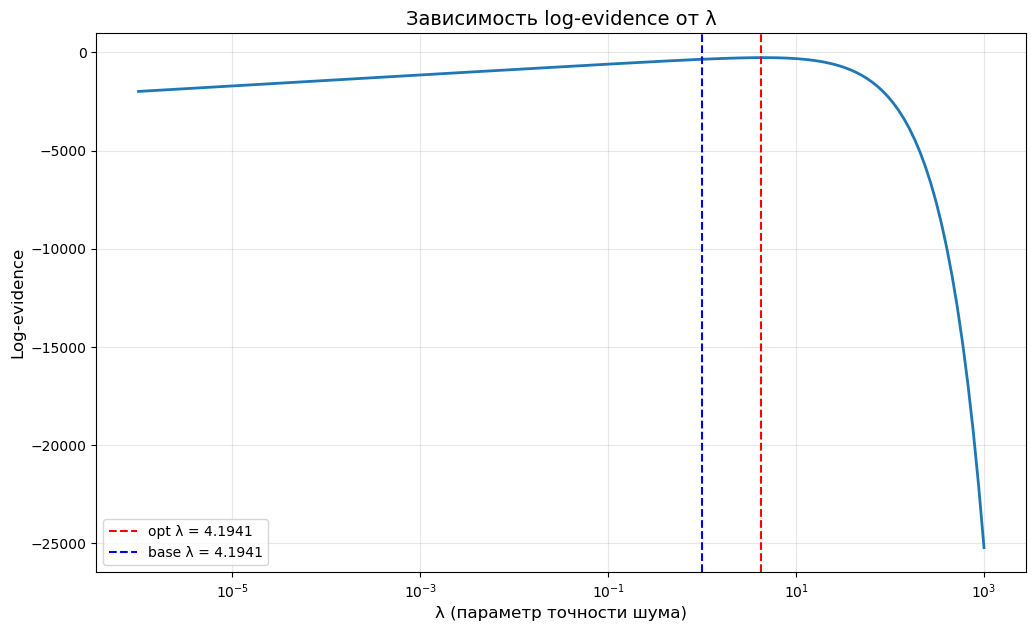

In [15]:
def log_evidence(lamb, X, y, alpha):
    n, m = X.shape

    # Матрица A = αI + λX^T X
    A = alpha * np.eye(m) + lamb * X.T @ X

    # Апостериорное среднее m_N = λA^(-1)X^T y
    # Решаем систему A * m_N = λX^T y
    m_N = lamb * np.linalg.solve(A, X.T @ y)

    # Вычисляем E(m_N) = (λ/2)||y - Xm_N||² + (α/2)||m_N||²
    residual = y - X @ m_N
    E_mN = (lamb / 2) * np.sum(residual ** 2) + (alpha / 2) * np.sum(m_N ** 2)

    # Вычисляем ln|A| через знак и логарифм определителя
    sign, logdet_A = np.linalg.slogdet(A)

    # Полная формула log-evidence
    log_ev = (m / 2) * np.log(alpha) + (n / 2) * np.log(lamb) - E_mN - (1 / 2) * logdet_A - (n / 2) * np.log(2 * np.pi)

    return log_ev

lambdas = np.logspace(-6, 3, 160)
log_evidences = []


for lamb in lambdas:
    log_ev = log_evidence(lamb, X, y, alpha)
    log_evidences.append(log_ev)

log_evidences = np.array(log_evidences)

optimal_idx = np.argmax(log_evidences)
optimal_lambda = lambdas[optimal_idx]

print(f"optimum lambda: {optimal_lambda:.4f}")
print(f"Log-evidence for opt lambda: {log_evidences[optimal_idx]:.4f}")

##### plotting #####

plt.figure(figsize=(12, 7))

plt.plot(lambdas, log_evidences, linewidth=2)
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'opt λ = {optimal_lambda:.4f}')
plt.axvline(1, color='blue', linestyle='--', label=f'base λ = {optimal_lambda:.4f}')
plt.xscale('log')
plt.xlabel('λ (параметр точности шума)', fontsize=12)
plt.ylabel('Log-evidence', fontsize=12)
plt.title('Зависимость log-evidence от λ', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()





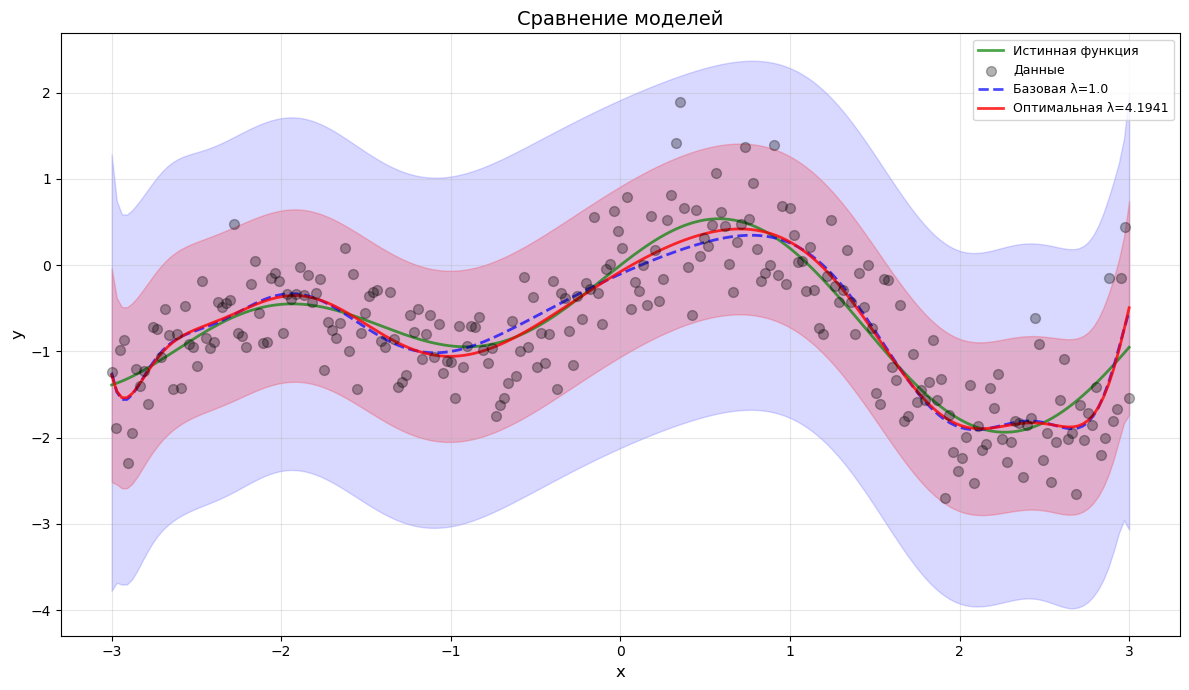

In [16]:
def bayesian_predict(X_train, y_train, X_test, alpha, lamb):
    n, m = X_train.shape

    A = alpha * np.eye(m) + lamb * X_train.T @ X_train

    m_N = lamb * np.linalg.solve(A, X_train.T @ y_train)

    mean_pred = X_test @ m_N

    S_N = np.linalg.inv(A)

    var_pred = (1 / lamb) + np.sum((X_test @ S_N) * X_test, axis=1)
    std_pred = np.sqrt(var_pred)

    return mean_pred, std_pred

base_lambda = 1.0

x_new = np.linspace(-3, 3, 200)
X_new = make_poly_features(x_new, degree)

mean_base, std_base = bayesian_predict(X, y, X_new, alpha, base_lambda)

mean_optimal, std_optimal = bayesian_predict(X, y, X_new, alpha, optimal_lambda)


plt.figure(figsize=(12, 7))

plt.plot(x_new, f_true(x_new), 'g-', linewidth=2, label='Истинная функция', alpha=0.7)

plt.scatter(x, y, s=50, c='black', label='Данные', zorder=5, alpha=0.3)

plt.plot(x_new, mean_base, 'b--', linewidth=2, label=f'Базовая λ={base_lambda}', alpha=0.7)
plt.fill_between(x_new, mean_base - 2 * std_base, mean_base + 2 * std_base, 
                 alpha=0.15, color='blue')

plt.plot(x_new, mean_optimal, 'r-', linewidth=2, label=f'Оптимальная λ={optimal_lambda:.4f}', alpha=0.8)
plt.fill_between(x_new, mean_optimal - 2 * std_optimal, mean_optimal + 2 * std_optimal, 
                 alpha=0.2, color='red')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Сравнение моделей', fontsize=14)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()

Линия с максимальным правдоподобием дальше от обобощения, но зато хорошо описывает данные